## Workspace setup. Libraries loading

In [1]:
import glob
import os
import time
from datetime import datetime
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from functools import partial

import tensorflow as tf
    
inputDataPrefix = ""

SLURM_CLUSTER_NAME=str(os.getenv("SLURM_CLUSTER_NAME"))
runOnCluster = False
if SLURM_CLUSTER_NAME == "prometheus":
    inputDataPrefix = "/net/people/plgakalinow/plggcmsml/"
    runOnCluster = True
elif SLURM_CLUSTER_NAME == "rysy":   
    inputDataPrefix = "/home/akalinow/"
    runOnCluster = True
else: 
    inputDataPrefix =  "/home/user1/scratch_ssd/akalinow/"
    runOnCluster = False
    

trainDataDir = inputDataPrefix+"/ProgrammingProjects/MachineLearning/TauTauMass/data/25_01_2021/"   
testDataDir = inputDataPrefix+"/ProgrammingProjects/MachineLearning/TauTauMass/data/29_06_2020/" 

massBins = tf.concat((tf.range(0.0, 300, 5, dtype=tf.float32), [300,9999.0]), axis=0)

## Use mixed precision policy: 32 bits for data, 16 bits for weights

In [2]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


## Start Tensorboard server

In [ ]:
if not runOnCluster:
    %load_ext tensorboard
    %tensorboard --logdir logs/fit --port=8008 --bind_all

## Utility functions

In [3]:
def fillPandasDataset(aBatch, df):
    features = aBatch[0]
    labels = aBatch[1]  
    fastMTTPredictions = aBatch[2] 
    predictions = model.predict(features, use_multiprocessing=True) 
    batch_df = pd.DataFrame(data={"genMass":labels, "fastMTT":fastMTTPredictions, "NN":finalModelAnswer(predictions), 
                                "metX":features[:,8],"metY":features[:,9]})
    return df.append(batch_df, ignore_index=True)


def generate_met_tf_weights(smeared_met, original_met, covariance):
    gauss2D = scipy.stats.multivariate_normal(mean=original_met, cov=covariance)
    met_tf_weights = gauss2D.pdf(smeared_met)
    met_tf_weights = np.reshape(met_tf_weights, (-1,1))
    met_tf_weights = met_tf_weights/gauss2D.pdf(original_met)
    return met_tf_weights


def argmax_2d(tensor):

  # flatten the Tensor along the height and width axes
  flat_tensor = tf.reshape(tensor, (-1))

  # argmax of the flat tensor
  argmax = tf.cast(tf.argmax(flat_tensor, axis=0), tf.int32)

  # convert indexes into 2D coordinates
  argmax_x = argmax // tf.shape(tensor)[1]
  argmax_y = argmax % tf.shape(tensor)[1]

  # stack and return 2D coordinates
  return tf.stack((argmax_x, argmax_y), axis=0)


def finalModelAnswer(predictions):
    predictions = np.cumsum(predictions, axis=1)>0.5
    predictions = np.argmax(predictions, axis=1)
    mass = label2Mass(predictions)
    return mass

## Data manipulation functions

In [41]:
columns = np.array(['eventWeight', 'sampleType', 'genMass', 'visMass', 'caMass',
       'fastMTTMass', 'covMET00', 'covMET01', 'covMET10', 'covMET11',
       'leg_1_E', 'leg_1_pX', 'leg_1_pY', 'leg_1_pZ', 'leg_2_E', 'leg_2_pX',
       'leg_2_pY', 'leg_2_pZ', 'leg_3_E', 'leg_3_pX', 'leg_3_pY', 'leg_3_pZ',
       'leg_4_E', 'leg_4_pX', 'leg_4_pY', 'leg_4_pZ', 'jet_1_E', 'jet_1_pX',
       'jet_1_pY', 'jet_1_pZ', 'jet_2_E', 'jet_2_pX', 'jet_2_pY', 'jet_2_pZ',
       'jet_3_E', 'jet_3_pX', 'jet_3_pY', 'jet_3_pZ', 'leg_2_decayMode'])
                    
def getFeaturesMask():
    featuresMask = np.full_like(columns, True, dtype=np.bool)
    featuresMask *= columns!="eventWeight"  
    featuresMask *= columns!="sampleType"  
    featuresMask *= columns!="genMass"    
    featuresMask *= columns!="visMass"
    featuresMask *= columns!="caMass"
    featuresMask *= columns!="fastMTTMass" 
    featuresMask *= columns!="covMET00"
    featuresMask *= columns!="covMET01"
    featuresMask *= columns!="covMET10"
    featuresMask *= columns!="covMET11"  
    #Leg 1
    #featuresMask *= columns!="leg_1_E"
    #featuresMask *= columns!="leg_1_pX"
    #featuresMask *= columns!="leg_1_pY"
    #featuresMask *= columns!="leg_1_pZ"
    #Leg 2
    #featuresMask *= columns!="leg_2_E"
    #featuresMask *= columns!="leg_2_pX"
    #featuresMask *= columns!="leg_2_pY"
    #featuresMask *= columns!="leg_2_pZ"
    #featuresMask *= columns!="leg_2_decayMode"
    #MET passed as jet_1
    featuresMask *= columns!="jet_1_E"
    #featuresMask *= columns!="jet_1_pX"
    #featuresMask *= columns!="jet_1_pY"
    featuresMask *= columns!="jet_1_pZ"
    #Jets
    featuresMask *= columns!="jet_2_E"
    featuresMask *= columns!="jet_2_pX"
    featuresMask *= columns!="jet_2_pY"
    featuresMask *= columns!="jet_2_pZ"
    featuresMask *= columns!="jet_3_E"
    featuresMask *= columns!="jet_3_pX"
    featuresMask *= columns!="jet_3_pY"
    featuresMask *= columns!="jet_3_pZ" 
    #Generated legs
    featuresMask *= columns!="leg_3_E"
    featuresMask *= columns!="leg_3_pX"
    featuresMask *= columns!="leg_3_pY"
    featuresMask *= columns!="leg_3_pZ"
    #
    featuresMask *= columns!="leg_4_E"
    featuresMask *= columns!="leg_4_pX"
    featuresMask *= columns!="leg_4_pY"
    featuresMask *= columns!="leg_4_pZ"
    #
    return featuresMask                   

def mass2Label(tensor):
    tensor = tf.searchsorted(massBins, tensor, side='left')
    return tensor
    
def label2Mass(tensor): 
    massValues = tf.gather(massBins, tensor)
    return tf.where(massValues<300, massValues, [300]) 

def getFeature(name, dataRow):
    columnIndex = np.where(columns == name)[0][0]  
    return dataRow[:,columnIndex]

def modifyFeatures(dataRow, batchSize, isTrain=False):
    columnsMask = getFeaturesMask()
    features = tf.boolean_mask(dataRow, columnsMask, axis=1)
    genMass = getFeature("genMass", dataRow)
    labels = genMass
    labels.set_shape([batchSize,])
    
    if isTrain:
        labels = mass2Label(labels)
        return (features, labels)
    else:
        fastMTT= getFeature("fastMTTMass", dataRow)
        fastMTT.set_shape([batchSize,])  
        visMass = getFeature("visMass", dataRow)
        visMass.set_shape([batchSize,])  
        covariance = getCovariance(dataRow)
        return (features, labels, fastMTT, visMass, covariance)
    return dataRow
    
def loadDataset(filePaths, isTrain, nEpochs=1, batchSize=1):   
    parquetFile = filePaths[0]
    df = pd.read_parquet(parquetFile)
    df = df.astype('float32')
    dataset = tf.data.Dataset.from_tensor_slices(df.values)
    dataset = dataset.batch(batchSize, drop_remainder=True)
    dataset = dataset.map(lambda x: modifyFeatures(x, batchSize, isTrain), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(1E-10)
    tf.print("Execution time:", time.perf_counter() - start_time)
    
   
def getCovariance(dataRow):
    
    covScaling = 60000.0
    #covScaling = 1.0
    cov00 = getFeature("covMET00", dataRow)*covScaling
    cov01 = getFeature("covMET01", dataRow)
    cov10 = getFeature("covMET10", dataRow)
    cov11 = getFeature("covMET11", dataRow)*covScaling
    return (cov00, cov01, cov10, cov11)

def generate_smeared_batch(dataRow, gridSize=10):
    
        cov = tf.reshape(dataRow[4],(-1,2,2))[0]
        leg1_x_y = dataRow[0][0][1:3]
        leg2_x_y = dataRow[0][0][5:7]  
        met = dataRow[0][0][-3:-1] 
        visMass = dataRow[3]
        
        x1, x2 = tf.meshgrid(tf.linspace(0.01, 0.99, gridSize), tf.linspace(0.01, 0.99, gridSize))
        x1 = tf.reshape(x1,(-1,1))
        x2 = tf.reshape(x2,(-1,1))
        testMass = visMass/tf.sqrt(x1*x2)
        testMass = tf.reshape(testMass, (gridSize*gridSize, ))
        
        leg1_x_y = tf.broadcast_to(leg1_x_y, (gridSize*gridSize, 2))
        leg2_x_y = tf.broadcast_to(leg2_x_y, (gridSize*gridSize, 2))
        x1 = tf.broadcast_to(x1, (x1.shape[0], 2))
        x2 = tf.broadcast_to(x2, (x2.shape[0], 2))
        smeared_met = (1/x1-1)*leg1_x_y + (1/x2-1)*leg2_x_y
                 
        smeared_metTot = tf.math.sqrt(smeared_met[:,0]**2 + smeared_met[:,1]**2)
        smeared_metTot = tf.reshape(smeared_metTot, (-1,1))
        
        features = dataRow[0][0][:]   
        numberOfFeatures = features.shape[0]
        features = tf.broadcast_to(features, (gridSize*gridSize,numberOfFeatures)) 
        decayModeColumn = features[:,-1]
        decayModeColumn = tf.reshape(decayModeColumn, (gridSize*gridSize,1))  
        dataRow = tf.concat([features[:,:-4], smeared_metTot, smeared_met, decayModeColumn], axis=1)  
        
        probabilityThreshold = 0.1
        gauss2D = multivariate_normal(mean=met, cov=cov)
        indices = gauss2D.pdf(smeared_met)>gauss2D.pdf(met)*probabilityThreshold 
        dataRow = tf.boolean_mask(dataRow, indices, axis=0)
        
        return dataRow, testMass  
    
def smearedMETgenerator(dataset, gridSize):  
     for dataRow in dataset:
      smearedBatch, testMass = generate_smeared_batch(dataRow, gridSize)
      smearedBatchSize = smearedBatch.shape[0]
      labels = tf.broadcast_to(dataRow[1], (smearedBatchSize,))
      fastMTTPredictions = tf.broadcast_to(dataRow[2], (smearedBatchSize,))
      original_met = dataRow[0][0,-3:-1] 
      covariance = tf.transpose(dataRow[4])
      covariance = tf.broadcast_to(covariance, (smearedBatchSize, 4))   
      yield (smearedBatch, labels, fastMTTPredictions, covariance, original_met, testMass)  

## Data reading test

Index(['eventWeight', 'sampleType', 'genMass', 'visMass', 'caMass',
       'fastMTTMass', 'covMET00', 'covMET01', 'covMET10', 'covMET11',
       'leg_1_E', 'leg_1_pX', 'leg_1_pY', 'leg_1_pZ', 'leg_2_E', 'leg_2_pX',
       'leg_2_pY', 'leg_2_pZ', 'leg_3_E', 'leg_3_pX', 'leg_3_pY', 'leg_3_pZ',
       'leg_4_E', 'leg_4_pX', 'leg_4_pY', 'leg_4_pZ', 'jet_1_E', 'jet_1_pX',
       'jet_1_pY', 'jet_1_pZ', 'jet_2_E', 'jet_2_pX', 'jet_2_pY', 'jet_2_pZ',
       'jet_3_E', 'jet_3_pX', 'jet_3_pY', 'jet_3_pZ', 'leg_2_decayMode'],
      dtype='object')
testMass tf.Tensor([17778.99     1786.8558   1786.8558    179.58575], shape=(4,), dtype=float32)
dataRow (<tf.Tensor: shape=(1, 11), dtype=float32, numpy=
array([[ 126.78529 ,   40.132748,  -17.92807 , -118.92201 ,   65.92982 ,
         -42.145084,   -9.429026,   49.80325 ,   36.072815,  -22.734362,
           2.      ]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([287.84766], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=floa

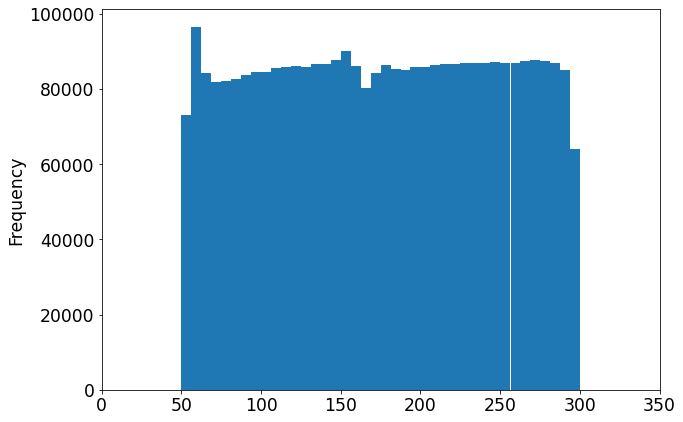

In [32]:
trainFileNames = glob.glob(trainDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8.gzip')
#trainFileNames = glob.glob(trainDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8_smearMET.gzip')
#trainFileNames = glob.glob(trainDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_DY_ggH125.gzip')
train_dataset = loadDataset(trainFileNames, isTrain=False, nEpochs=1, batchSize=1)

#dataset = train_dataset
#benchmark(dataset)
#benchmark(dataset.prefetch(tf.data.experimental.AUTOTUNE))

parquetFile = trainFileNames[0]
df = pd.read_parquet(parquetFile)
df = df.astype('float16')
print(df.columns)
ax = df["genMass"].plot.hist(bins=40, label="genMass", xlim=(0,350))
        
for dataRow in train_dataset.take(1):
  smearedMETbatch = generate_smeared_batch(dataRow, gridSize=2)
  print("dataRow",dataRow)  
  print("smeared:",smearedMETbatch)  
  break   

## Define models

In [12]:
cumulativePosteriorCut = 0.5

def pull_mean(y_true, y_pred):    
    predictions = tf.math.cumsum(y_pred, axis=1)>cumulativePosteriorCut
    predictions = tf.math.argmax(predictions, axis=1)   
    predictions = label2Mass(predictions)
    predictions = tf.reshape(predictions, (-1,1))
    labels = label2Mass(tf.cast(y_true, tf.int32))
    pull = (labels - predictions)/labels   
    mean = tf.math.reduce_mean(pull, axis=0)
    return mean 
    
def pull_sigma(y_true, y_pred):
    predictions = tf.math.cumsum(y_pred, axis=1)>cumulativePosteriorCut
    predictions = tf.math.argmax(predictions, axis=1)   
    predictions = label2Mass(predictions)
    predictions = tf.reshape(predictions, (-1,1))
    labels = label2Mass(tf.cast(y_true, tf.int32))
    pull = (labels - predictions)/labels  
    variance = tf.math.reduce_variance(pull, axis=0) 
    return tf.sqrt(variance) 

custom_objects={'pull_mean': pull_mean,
                'pull_sigma':pull_sigma
               }

  
def getModel():  
    nMassBins =  massBins.shape[0]
    nInputs = np.sum(getFeaturesMask())
    inputs = tf.keras.Input(shape=(nInputs,), name="features")
    x = inputs
    for iLayer in range(0,16):
        x = tf.keras.layers.Dense(nInputs*nInputs, activation="relu", name="layer_{}".format(iLayer))(x)
            
    outputs = tf.keras.layers.Dense(nMassBins, activation="softmax", name = "mass")(x)              
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="NN_SVFit")
    
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                                decay_steps=10000,
                                                                decay_rate=0.95,
                                                                staircase=True)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy',pull_mean, pull_sigma])
    tf.keras.utils.plot_model(model, 'fig_png/ML_model.png', show_shapes=True)
    return model

## Train the model

In [ ]:
current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
print("Training start. Current Time =", current_time)

trainFileNames = glob.glob(trainDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8.gzip')
testFileNames = glob.glob(testDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8.gzip')

train_dataset = loadDataset(trainFileNames, isTrain=True, nEpochs=1, batchSize=8*1024)
validation_dataset = loadDataset(testFileNames, isTrain=True, nEpochs=1, batchSize=16*1024)

model = getModel()
nEpochsSaved = 50
checkpoint_path = "training/model_{epoch:04d}"
#model = tf.keras.models.load_model(checkpoint_path.format(epoch=nEpochsSaved), custom_objects=custom_objects)

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=(130,150))

nEpochs = 2000
history = model.fit(train_dataset, epochs=nEpochs,
                    use_multiprocessing=True,
                    verbose=0,
                    shuffle=False,
                    validation_data=validation_dataset.take(1),
                    #callbacks=[tensorboard_callback] 
                   )

# Save the whole model
path = "training/model_{epoch:04d}"
model.save(path.format(epoch=nEpochs), save_format='tf')
#Save model weights
path = "training/model_weights_{epoch:04d}.ckpt"
model.save_weights(path.format(epoch=nEpochs))

current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
print("Training end. Current Time =", current_time)

## Model evaluation

Current Time = Mar 05 2021 17:03:44
fastMTT:
Mass range: Z90 mean pull: 0.014 pull RMS: 0.165 RMS/90: 0.0018
Mass range: H125 mean pull: 0.004 pull RMS: 0.160 RMS/125: 0.0013
NN:
Mass range: Z90 mean pull: 0.041 pull RMS: 0.081 RMS/90: 0.0009
Mass range: H125 mean pull: 0.026 pull RMS: 0.097 RMS/125: 0.0008


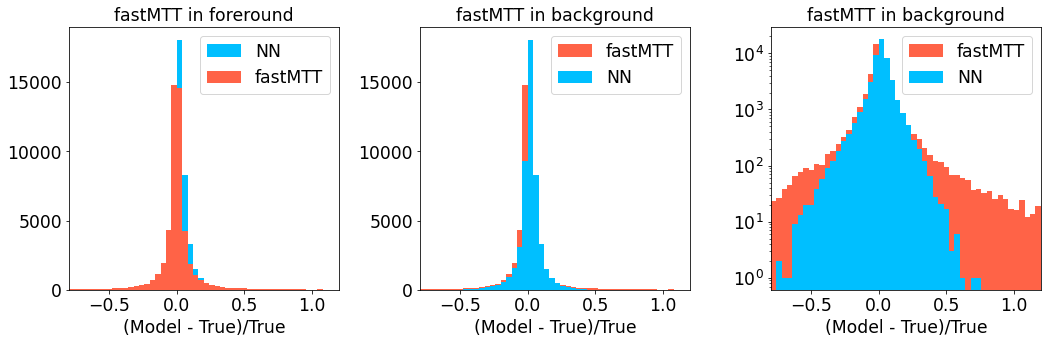

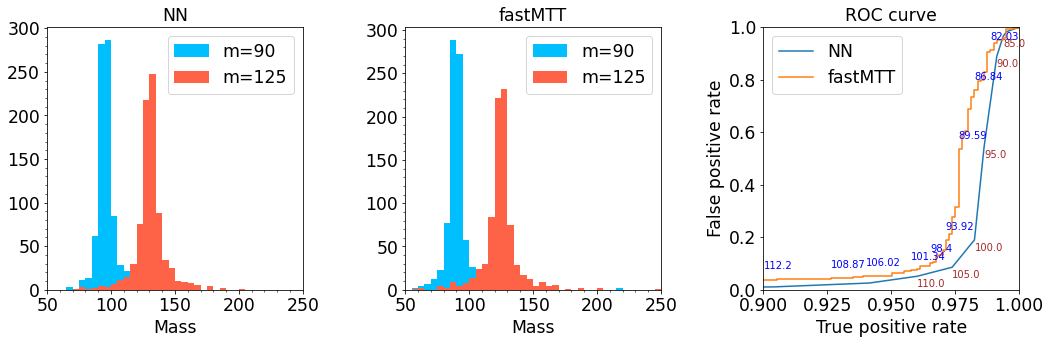

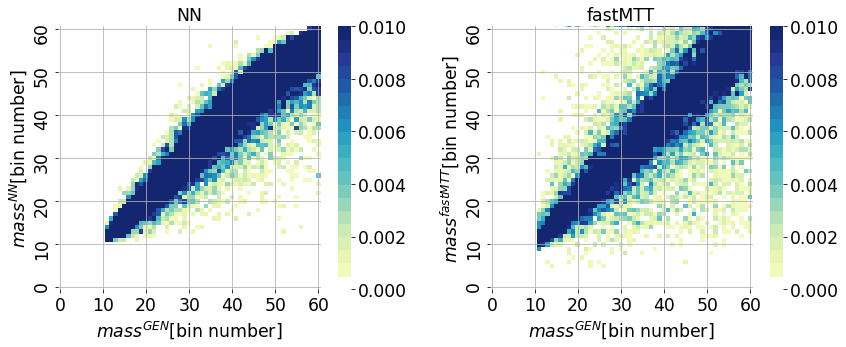

In [13]:
import importlib
import plottingFunctions as plf
importlib.reload(plf)

if not runOnCluster:
    nEpochsSaved = 5000   
    checkpoint_path = "training/model_{epoch:04d}"
    model = tf.keras.models.load_model(checkpoint_path.format(epoch=nEpochsSaved), custom_objects=custom_objects)
       
    current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
    print("Current Time =", current_time)

    testFileNames = glob.glob(trainDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8.gzip') 
    test_dataset = loadDataset(testFileNames, isTrain=False, nEpochs=1, batchSize=10000)

    df = pd.DataFrame(columns = ["genMass", "fastMTT", "NN", "metX", "metY"])          
    for aBatch in test_dataset.take(5):
        df = fillPandasDataset(aBatch, df)

    plf.plotPull(df, minX=-0.8, maxX=1.2)
    plf.compareDYandH125(df)
    plf.plotCM(df, vmax=0.01, mass2Label=mass2Label)  

## Apply MET smearing

Current Time = Mar 05 2021 17:24:42
tf.Tensor([14031.438    1410.2125   1410.2125    141.73169], shape=(4,), dtype=float32)


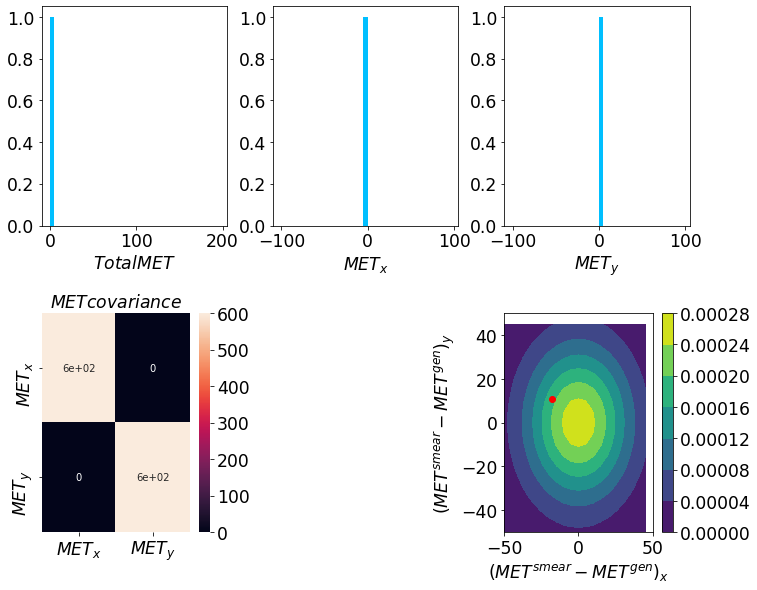

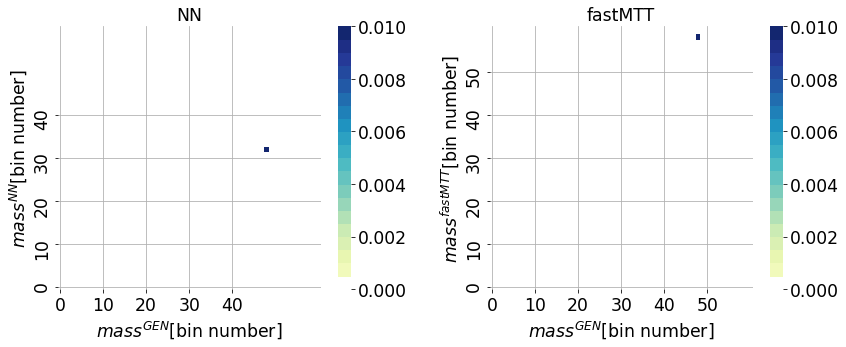

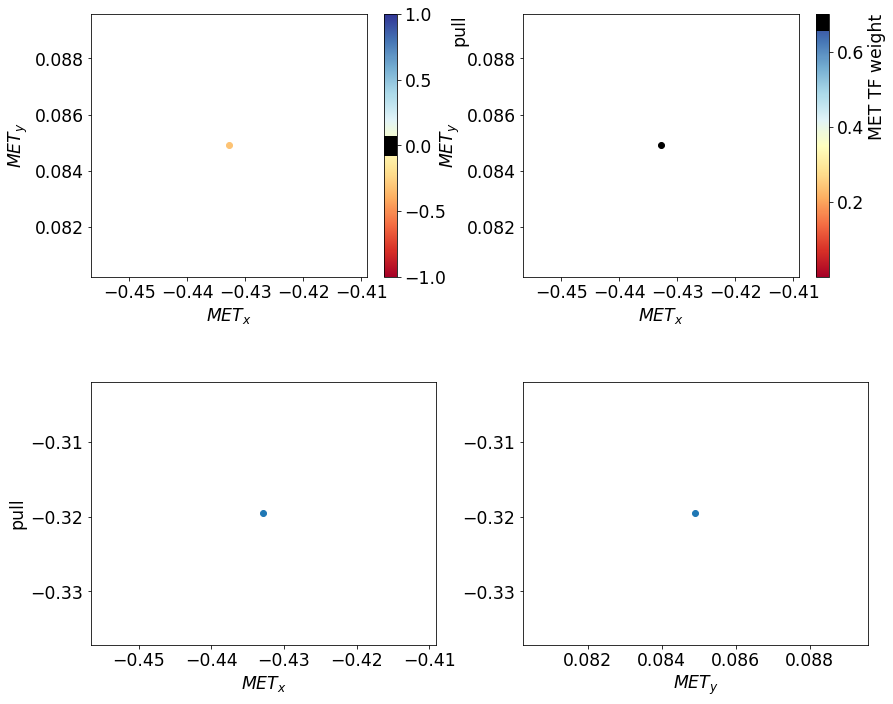

In [43]:
import importlib
import plottingFunctions as plf
importlib.reload(plf)

if not runOnCluster:
    nEpochsSaved = 5000   
    checkpoint_path = "training/model_{epoch:04d}"
    model = tf.keras.models.load_model(checkpoint_path.format(epoch=nEpochsSaved), custom_objects=custom_objects)
    
    current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
    print("Current Time =", current_time)

    testFileNames = glob.glob(testDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8.gzip') 
    test_dataset = loadDataset(testFileNames, isTrain=False, nEpochs=1, batchSize=1)

    generator = partial(smearedMETgenerator, test_dataset, 2)  
    smeared_Dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))

    df = pd.DataFrame(columns = ["genMass", "fastMTT", "NN", "metX", "metY"])          
    for aBatch in smeared_Dataset.take(1):
        
        covariance = np.reshape(aBatch[3][0], (2,2))
        original_met = np.reshape(aBatch[4:5], (2))
        smeared_met = np.reshape(aBatch[0][:,-3:-1], (-1,2))
        testMass = aBatch[5]
        print(testMass)

        met_tf_weights = generate_met_tf_weights(smeared_met, original_met, covariance)    

        plf.plotMET(smeared_met, original_met, covariance)
        df = fillPandasDataset(aBatch, df)
        plf.plotCM(df, vmax=0.01, mass2Label=mass2Label)

    plf.pullNN_vs_MET(df, met_tf_weights)    
    #for aBatch in smeared_Dataset.take(1000): 
    #    df = fillPandasDataset(aBatch, df) 
    #print(df)

In [ ]:
testFileNames = glob.glob(testDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8.gzip') 
test_dataset = loadDataset(testFileNames, isTrain=False, nEpochs=1, batchSize=1)

generator = partial(smearedMETgenerator, test_dataset, 2)  
smeared_Dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))
     
nnMTT = np.zeros_like(massBins)
fastMTT = np.array([])
truth = np.array([])   

nEpochsSaved = 5000
checkpoint_path = "training/model_{epoch:04d}"
model = tf.keras.models.load_model(checkpoint_path.format(epoch=nEpochsSaved), custom_objects=custom_objects)
    
for aBatch in smeared_Dataset.take(1).as_numpy_iterator():
    labels = np.reshape(aBatch[1], [-1])
    fastMTTPredictions = np.reshape(aBatch[2], [-1])
    features = aBatch[0]
    original_met = np.reshape(aBatch[4:5], (2))
    smeared_met = np.reshape(features[:,-3:-1], (-1,2))
    predictions = model.predict(features, use_multiprocessing=True) 
    
    covariance = np.array(aBatch[3][0])
    covariance = np.reshape(covariance, (2,2)) 
    
    gauss2D = scipy.stats.multivariate_normal(mean=original_met, cov=covariance)
    met_tf_weights = gauss2D.pdf(smeared_met)
    met_tf_weights = tf.reshape(met_tf_weights, (-1,1))
    met_tf_weights = met_tf_weights/gauss2D.pdf(original_met)
    
    predictions_with_weights = tf.math.multiply(predictions, met_tf_weights)
    resultIndex = argmax_2d(predictions_with_weights)
    resultValue = label2Mass(resultIndex[1])
    
    nnMTT = np.vstack((nnMTT,predictions_with_weights[resultIndex[0]]))
    fastMTT = np.append(fastMTT, fastMTTPredictions[0])
    truth = np.append(truth, labels[0])
    
    '''
    print("label",labels[0])
    print("predictions.shape",predictions.shape)
    print("met_tf_weights.shape",met_tf_weights.shape)
    print("resultIndex",resultIndex)
    print("resultIndex[0]",resultIndex.numpy()[0])
    print("best weight",met_tf_weights[resultIndex.numpy()[0]])
    '''
    
    
    plotMET(smeared_met, original_met, covariance)
    '''
    plotPull(labels=labels, predictions=predictions, fastMTTPredictions=fastMTTPredictions)
    plotPull(labels=labels, predictions=predictions_with_weights, fastMTTPredictions=fastMTTPredictions)
    plotPosterior(massGen = labels[0], labels=labels, predictions=predictions, indices=[resultIndex.numpy()[0]]) 
    plotPosterior(massGen = labels[0], labels=labels, predictions=predictions, indices=[1]) 
    plotPosterior(massGen = labels[0], labels=labels, predictions=predictions, indices=[2]) 
    plotPosterior(massGen = labels[0], labels=labels, predictions=predictions, indices=[3]) 
    plotPosterior(massGen = labels[0], labels=labels, predictions=predictions, indices=[4]) 
    plotPosterior(massGen = labels[0], labels=labels, predictions=predictions, indices=[5]) 
    plotPosterior(massGen = labels[0], labels=labels, predictions=predictions, indices=[6])
    plotPosterior(massGen = labels[0], labels=labels, predictions=predictions, indices=[8])
    #plotPull(labels=labels, predictions=predictions, fastMTTPredictions=fastMTTPredictions)
    #plotCM(labels=labels, predictions=predictions, fastMTTPredictions=fastMTTPredictions)
    #compareDYandH125(labels=labels, predictions=predictions, fastMTTPredictions=fastMTTPredictions)  
    break
    '''
    
    
nnMTT = nnMTT[1:,:] 
#plotPull(labels=truth, predictions=nnMTT, fastMTTPredictions=fastMTT)
#compareDYandH125(labels=truth, predictions=nnMTT, fastMTTPredictions=fastMTT) 